<h2>2022-05-17: USE WITH 'fastsim_upd' BRANCH</h2>

In [1]:
#del sys.path[...]
#sys.path.insert(0,'.../epix') # 'fastsim_upd' branch

In [2]:
import warnings
warnings.filterwarnings("ignore", message="You are setting a default value")

import time
import sys

import numba
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from collections import Counter
import matplotlib.ticker as ticker

import cutax
print(f"cutax : {cutax.__version__}")

import epix
import straxen
straxen.print_versions()

from epix.simulator.fast_simulator import StraxSimulator

2022-07-14 01:38:10,553 - admix - WARNING - Initializing utilix DB failed. You cannot do database operations


DB initialization failed
cutax : 1.13.0


*** Detector definition message ***
You are currently using the default XENON10 template detector.



Using nestpy version 1.5.4


<h2>Convenience functions</h2>

In [3]:
def ax_config(ax, title = None, xbounds = None, ybounds = None, xlabel = None, ylabel = None, 
              grid_M_X = True, grid_M_Y = True, grid_m_X = True, grid_m_Y = True,
              colorbar = False, clabel='', sci = False, yscale = None, xscale = None, fontsize=20):
    Label_fontname = 'serif'
    if title != None: ax.set_title(title, fontname=Label_fontname)
    if xbounds != None: ax.set_xlim(xbounds[0], xbounds[1])
    if ybounds != None: ax.set_ylim(ybounds[0], ybounds[1])
    if xlabel != None: ax.set_xlabel(xlabel, fontname=Label_fontname)
    if ylabel != None: ax.set_ylabel(ylabel, fontname=Label_fontname)
    if xscale != None: ax.set_xscale(xscale)
    if yscale != None: ax.set_yscale(yscale)
        
    if isinstance(sci, str):
        plt.ticklabel_format(style='sci', axis=sci, scilimits=(0,0))
        
    if xscale == 'log':
        locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
        ax.xaxis.set_minor_locator(locmin)
        ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    else:
        ax.xaxis.set_minor_locator(AutoMinorLocator(10))
        
    if yscale == 'log':
        locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
        ax.yaxis.set_minor_locator(locmin)
        ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    else:
        ax.yaxis.set_minor_locator(AutoMinorLocator(10))
    
    if grid_M_X:
        ax.xaxis.grid(grid_M_X, which='major', color='black', alpha=0.1)
    if grid_M_Y:
        ax.yaxis.grid(grid_M_Y, which='major', color='black', alpha=0.1)
    if grid_m_X:
        ax.xaxis.grid(grid_m_X, which='minor', color='gray', alpha=0.1)
    if grid_m_Y:
        ax.yaxis.grid(grid_m_Y, which='minor', color='gray', alpha=0.1)
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)
        
    if isinstance(colorbar,str):
        plt.colorbar().set_label(label = colorbar,size=12, weight = None)
    elif colorbar:
        plt.colorbar(label = clabel)
    else:
        pass
    
    ax.set_facecolor('white')

<h2>Path</h2>

In [4]:
# AmBe source, I-Belt position, tungsten cylinder collimator, 1E4 primaries
raw_data_dir = '/dali/lgrandi/xenonnt/simulations/ambe_ibelt/mc_v4.4.0/tungsten_cylinder_GEANT4/'
raw_data_filename='ibc_008f8efb-99ac-475a-a83a-9c35cca8734d.root'

# Your local directory for strax output
strax_data_dir = '/scratch/midway2/pkavrigin/strax/'

In [5]:
# Clear old strax output
# %rm -r /scratch/midway2/pkavrigin/strax/*

<h2>Parameters</h2>

In [6]:
st = cutax.contexts.xenonnt_sim_chain_SR0v2_cmt_v8(output_folder=strax_data_dir,)

run_id = 'fastsim0'

# epix config
epix_args={'path':raw_data_dir,
           'file_name':raw_data_filename, 
           'debug':True,           
           'entry_start':0,
           'entry_stop':None,
           'cut_by_eventid':False,
           'micro_separation_time':10.0,
           'micro_separation':0.005,
           'tag_cluster_by':'energy',
           'max_delay':1e7,
           'source_rate':-1}

configuration_files={'nv_pmt_qe':'nveto_pmt_qe.json',
                     'photon_area_distribution':'XENONnT_spe_distributions_20210305.csv',
                     's1_pattern_map': 'XENONnT_s1_xyz_patterns_LCE_corrected_qes_MCva43fa9b_wires.pkl',
                     's2_pattern_map': 'XENONnT_s2_xy_patterns_GXe_LCE_corrected_qes_MCv4.3.0_wires.pkl',
                     's1_lce_correction_map': False,
                     's2_correction_map': False}

_gains = [1 for i in range(494)]

# List of disabled PMTs
#pmt_off = [156, 164, 177, 350, 352, 354, 362, 386, 393, 427, 313]
#for _pmt in pmt_off:
#    _gains[_pmt]=0
    
# Set up configuration
st.config.update(dict(fax_config='fax_config_nt_sr0_v2.json',                      
                      g4_file=raw_data_dir+raw_data_filename,
                      epix_config=epix_args,
                      configuration_files=configuration_files,
                      fax_config_overrides={"detector":"XENONnT",
                                            "gains": _gains,
                                            "n_top_pmts":253,
                                            "n_tpc_pmts":494,
                                            #"enable_field_dependencies": {                                                
                                            #    "survival_probability_map": False,
                                            #    "drift_speed_map": False,
                                            #    "diffusion_longitudinal_map": False,
                                            #    "diffusion_radial_map": False,
                                            #    "diffusion_azimuthal_map": False}
                                           }
                     ))

st.register(StraxSimulator)

epix.simulator.fast_simulator.StraxSimulator

<h2>Run simulation</h2>

In [7]:
start_time = time.time()

st.make(run_id,'events_tpc')
st.make(run_id, 'events_nveto')

t = time.time()
print(f'It took {(t - start_time):.1f} [s] to finish the simulation.')

Removing data in /scratch/midway2/pkavrigin/strax/fastsim0-events_tpc-krpykptig4 to overwrite
Removing data in /scratch/midway2/pkavrigin/strax/fastsim0-events_nveto-krpykptig4 to overwrite


/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/wfsim/load_resource.py:262: RuntimeWarning: invalid value encountered in true_divide
  orig_aft_=np.mean((s2map_topeff_/s2map_toteff_)[s2map_toteff_>0.0])


epix configuration:  {'path': '/dali/lgrandi/xenonnt/simulations/ambe_ibelt/mc_v4.4.0/tungsten_cylinder_GEANT4/', 'file_name': 'ibc_008f8efb-99ac-475a-a83a-9c35cca8734d.root', 'debug': True, 'entry_start': 0, 'entry_stop': None, 'cut_by_eventid': False, 'micro_separation_time': 10.0, 'micro_separation': 0.005, 'tag_cluster_by': 'energy', 'max_delay': 10000000.0, 'source_rate': -1, 'detector_config': [<epix.detector_volumes.SensitiveVolume object at 0x7fca360f32b0>, <epix.detector_volumes.SensitiveVolume object at 0x7fca360f3340>], 'outer_cylinder': {'max_z': 7.3936, 'min_z': -154.6555, 'max_r': 66.4}}
Total entries in input file = 9474
Starting to read from output file entry 0
It took 69.6946 sec to load data.
Finding clusters of interactions with a dr = 0.005 mm and dt = 10.0 ns


/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/awkward/_connect/_numba/__init__.py:28: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not checked_version and distutils.version.LooseVersion(
/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/awkward/_connect/_numba/__init__.py:30: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < distutils.version.LooseVersion("0.50"):


It took 60.8439 sec to find clusters.
It took 20.0987 sec to merge clusters.
Removing clusters not in volumes: TPC BelowCathode
Number of clusters before: 286055
Number of clusters after: 285479
Assigning electric field to clusters
Generating photons and electrons for events


/home/pkavrigin/epix/notebooks/epix/quanta_generation.py:50: UserWarning: Energy deposition of 203.235595703125 keV beyond NEST validity for NR model of 200 keV - Remove Interaction
  warnings.warn(f"Energy deposition of {en} keV beyond NEST validity for NR model of 200 keV - Remove Interaction")
/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/numpy/lib/function_base.py:2387: RuntimeWarning: divide by zero encountered in func (vectorized)
  outputs = ufunc(*inputs)
/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/numpy/lib/function_base.py:2387: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


It took 20.1240 sec to get quanta.
Clean event separation


/home/pkavrigin/epix/notebooks/epix/simulator/GenerateEvents.py:99: RuntimeWarning: invalid value encountered in true_divide
  instructions['cs1'] = instructions['s1_area'] / resource.s1_map(event_positions)[:, 0]
/home/pkavrigin/epix/notebooks/epix/simulator/GenerateEvents.py:100: RuntimeWarning: invalid value encountered in true_divide
  instructions['alt_cs1'] = instructions['alt_s1_area'] / resource.s1_map(event_positions)[:, 0]


Source finished!
It took 278.1 [s] to finish the simulation.


<h2>events_tpc</h2>

In [8]:
_events_tpc = st.get_array(run_id, 'events_tpc')
df_events_tpc = pd.DataFrame(_events_tpc)
df_events_tpc

Loading events_tpc: |          | 0.00 % [00:00<?]

,time,endtime,s1_area,s2_area,cs1,cs2,alt_s1_area,alt_s2_area,alt_cs1,alt_cs2,x,y,z,alt_s2_x,alt_s2_y,alt_s2_z,drift_time,alt_s2_drift_time
0,0,1,1388.273829,6.414274e+05,6227.356051,6.719811e+05,1120.253481,2.857374e+05,5025.101784,2.924266e+05,-1.406246,-24.133157,-137.863922,23.881697,-5.138076,-107.469210,2.042428e+06,1.592136e+06
1,1000,1001,643.436711,4.175577e+05,5191.099205,5.221347e+05,503.153949,0.000000e+00,4059.330185,0.000000e+00,14.707835,59.885090,-30.426540,0.000000,0.000000,0.000000,4.507636e+05,0.000000e+00
2,2000,2001,738.750213,6.503504e+05,5379.946638,9.201952e+05,506.767109,0.000000e+00,3690.530246,0.000000e+00,58.574704,20.109972,-62.341898,0.000000,0.000000,0.000000,9.235837e+05,0.000000e+00
3,3000,3001,0.000000,0.000000e+00,NaN,0.000000e+00,0.000000,0.000000e+00,NaN,0.000000e+00,67.867320,0.218711,-81.193565,0.000000,0.000000,0.000000,1.202868e+06,0.000000e+00
4,4000,4001,498.884829,0.000000e+00,3147.274070,0.000000e+00,483.986020,6.019884e+04,3053.283166,7.675471e+04,61.441131,26.940234,-132.984547,58.864748,0.051092,-63.323260,1.970141e+06,9.381224e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2604,2615000,2615001,598.848004,2.149671e+05,3256.289824,3.081343e+05,499.609940,0.000000e+00,2716.673936,0.000000e+00,32.882353,54.475580,-129.284737,0.000000,0.000000,0.000000,1.915329e+06,0.000000e+00
2605,2616000,2616001,774.501728,7.130861e+05,5433.521786,9.132186e+05,578.202954,6.710653e+05,4056.386489,9.151446e+05,51.721256,19.769296,-69.112695,55.662658,16.396072,-84.752810,1.023892e+06,1.255597e+06
2606,2617000,2617001,1125.920828,4.305936e+02,5883.017951,6.554779e+02,865.255544,1.367451e+05,4521.022945,1.906115e+05,56.488606,32.672319,-140.653316,52.177153,22.615286,-125.980061,2.083753e+06,1.866371e+06
2607,2618000,2618001,605.127264,4.583315e+05,4591.514086,5.696922e+05,607.727221,0.000000e+00,4611.241736,0.000000e+00,50.699264,23.040669,-44.290073,0.000000,0.000000,0.000000,6.561492e+05,0.000000e+00


/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


[]

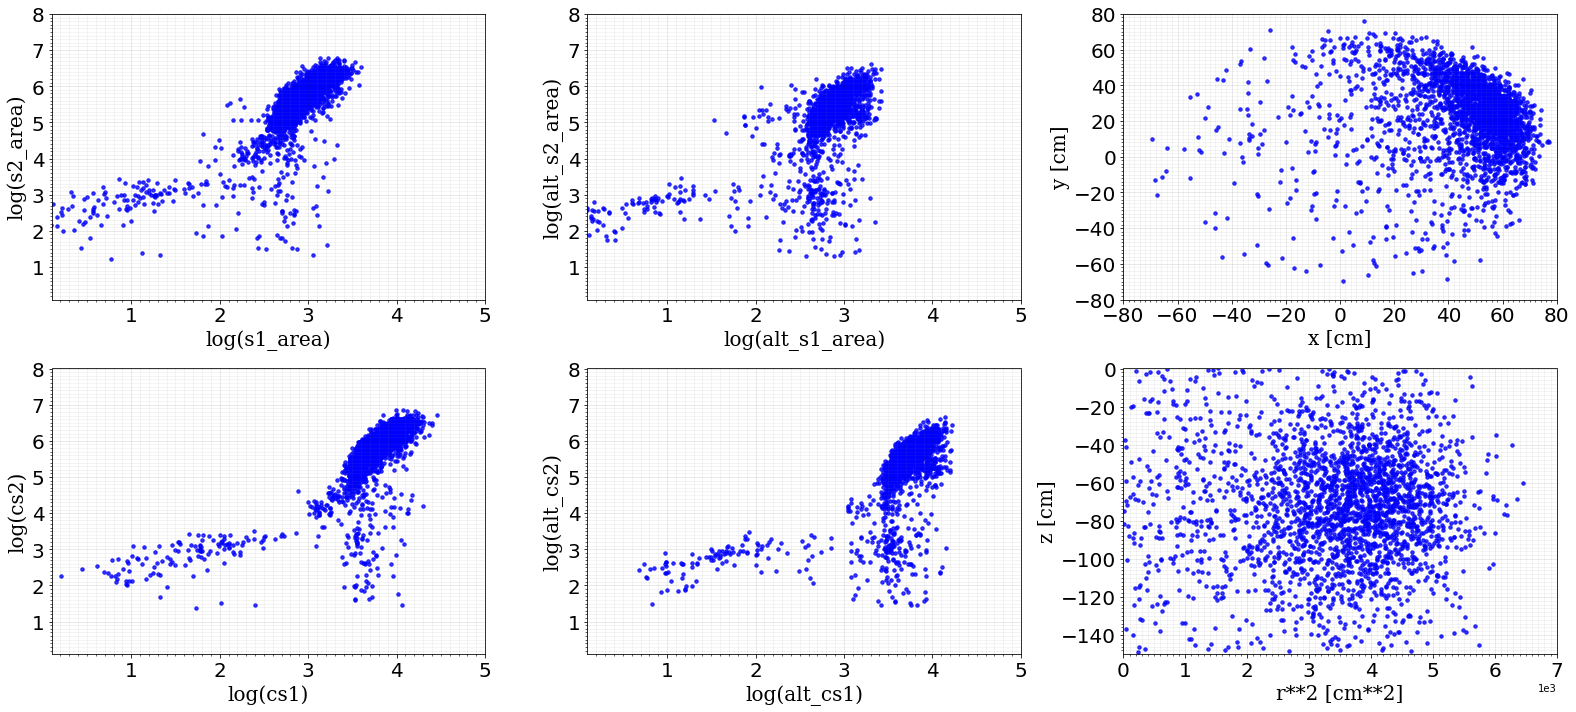

In [9]:
fig, ax = plt.subplots(2, 3, figsize=[22,10])

rr=[ [(0.1, 5.0), (0.1, 8.0)],
     [(0.1, 5.0), (0.1, 8.0)],    
     [(-80, 80), (-80, 80)],
     [(0.1, 5.0), (0.1, 8.0)],
     [(0.1, 5.0), (0.1, 8.0)],
     [(0.0, 7e3), (-150.0, 0.0)] ]

label_list = [ ['log(s1_area)', 'log(s2_area)'],
               ['log(alt_s1_area)', 'log(alt_s2_area)'],
               ['x [cm]','y [cm]'],
               ['log(cs1)', 'log(cs2)'],
               ['log(alt_cs1)', 'log(alt_cs2)'],
               ['r**2 [cm**2]', 'z [cm]'] ]

_ei = df_events_tpc

arr_list = [ [np.log10(_ei.s1_area), np.log10(_ei.s2_area)],
             [np.log10(_ei.alt_s1_area), np.log10(_ei.alt_s2_area)],
             [_ei.x, _ei.y],
             [np.log10(_ei.cs1), np.log10(_ei.cs2)],
             [np.log10(_ei.alt_cs1), np.log10(_ei.alt_cs2)], 
             [(_ei.x**2+_ei.y**2), _ei.z] ]

for ind, arr in enumerate(arr_list):
    _ax = ax[ind//3][ind%3]

    _ax.scatter(arr[0], 
                arr[1],
                color = 'blue',
                s=12,
                alpha=0.8)  

    ax_config(_ax, 
              xbounds = rr[ind][0],
              ybounds = rr[ind][1],
              xlabel=label_list[ind][0], 
              ylabel=label_list[ind][1])
    
    _ax.ticklabel_format(axis='x', style='sci', scilimits=(0,3))
    _ax.ticklabel_format(axis='y', style='sci', scilimits=(0,3))

plt.tight_layout()
plt.plot()

<h2>events_nveto</h2>

In [10]:
df_events_nv = st.get_df(run_id, 'events_nveto')
df_events_nv

Loading events_nveto: |          | 0.00 % [00:00<?]

,time,endtime,event_id,channel
0,28.653298,29.653298,0,2029
1,9.452021,10.452021,0,2033
2,31.092866,32.092866,0,2064
3,37.433017,38.433017,0,2069
4,153.717645,154.717645,0,2038
...,...,...,...,...
526000,16.586967,17.586967,9998,2069
526001,113.085300,114.085300,9998,2074
526002,10.039805,11.039805,9998,2058
526003,76.733456,77.733456,9998,2035
